### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from os import PathLike
import copy
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from typing import List, Tuple
from tqdm.notebook import tqdm

### Dataloader

In [2]:
# Create dataloader
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = np.genfromtxt(csv_file, delimiter=',', dtype=None, encoding=None, skip_header=True)
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.annotations[index][0]
        image = cv2.imread(img_path)
        left, forward, center = float(annotations[index][1]), float(annotations[index][2]), float(annotations[index][3])
        y_label = torch.tensor([left, forward, center])
        
        if transform:
            image = self.transform(image)

        return (image, y_label)
    
    def __len__(self):
        return len(self.annotations)

#### Transformer

In [3]:
# transform that makes it a tensor and crops the bottom third of the image
IMAGE_TRANSFORM = transforms.Compose([
    transforms.Lambda(lambda x: x[:,80:,:]),
    transforms.ToPILImage(),
    transforms.Resize((240, 80)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

#### Examples

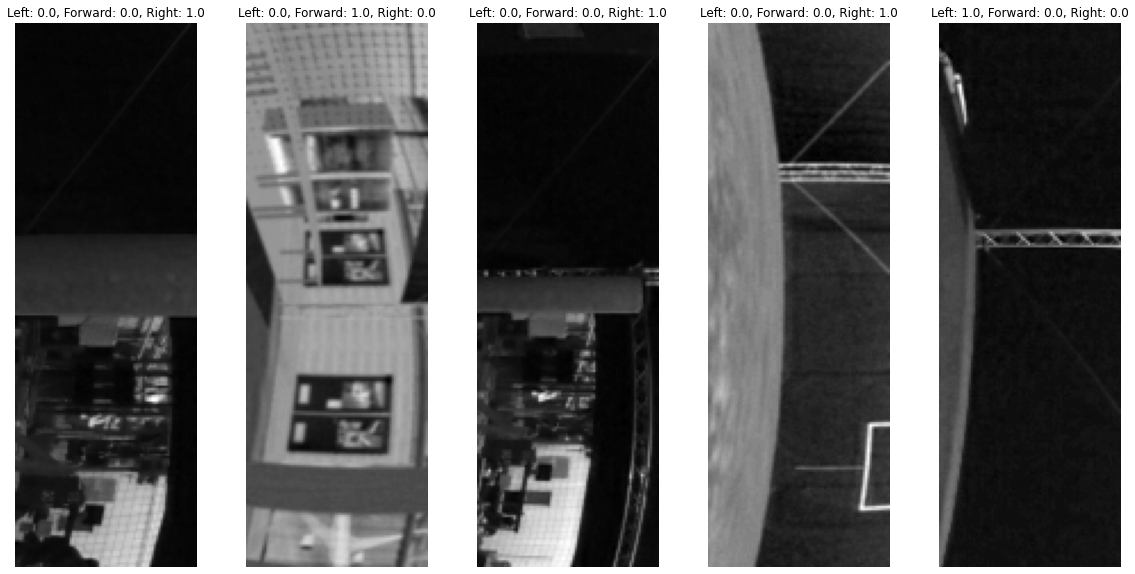

In [4]:
dataset = MyDataset('images_with_label.csv', transform=IMAGE_TRANSFORM)

# show 5 random grayscale images
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    image, label = dataset[random.randint(0, len(dataset))]
    ax[i].imshow(image.squeeze(0), cmap='gray')
    ax[i].set_title(f'Left: {label[0]}, Forward: {label[1]}, Right: {label[2]}')
    ax[i].axis('off')

# # show 5 random RGB images
# fig, ax = plt.subplots(1, 5, figsize=(20, 10))
# for i in range(5):
#     image, label = dataset[random.randint(0, len(dataset))]
#     ax[i].imshow(image.permute(1, 2, 0))
#     ax[i].set_title(f'Left: {label[0]}, Forward: {label[1]}, Center: {label[2]}')
#     ax[i].axis('off')
    
# # Show how many samples we have for each label
# left = 0
# forward = 0
# right = 0
# for i in range(len(dataset)):
#     _, label = dataset[i]
#     if label[0] == 1:
#         left += 1
#     elif label[1] == 1:
#         forward += 1
#     elif label[2] == 1:
#         right += 1

# print(f'Left: {left}, Forward: {forward}, Right: {right}')

#### Train, Val, Test dataloaders

In [5]:
def dataloaders(
        dataset_path: PathLike = 'images_with_label.csv',
        val_ratio: float = 0.2,
        test_ratio: float = 0.1,
        batch_size: int = 32,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Create dataloaders for the training, validation, and test sets.

    Args:
        val_ratio: The ratio of the dataset to use for validation.
        test_ratio: The ratio of the dataset to use for testing.
        batch_size: The number of samples in each batch.

    Returns:
        A tuple of DataLoaders for the training, validation, and test sets.
    """

    dataset = MyDataset(csv_file=dataset_path, transform=IMAGE_TRANSFORM)

    # Split the dataset into training, validation, and test sets
    num_samples = len(dataset)
    num_val_samples = int(val_ratio * num_samples)
    num_test_samples = int(test_ratio * num_samples)
    num_train_samples = num_samples - num_val_samples - num_test_samples
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [num_train_samples, num_val_samples, num_test_samples]
    )

    # Create DataLoaders for the training, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Create dataloaders
train_loader, val_loader, test_loader = dataloaders()

### Model

In [6]:
# Create a CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(4,4), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(4,4), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=(4,4), stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.dropout3 = nn.Dropout(0.1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(8352, 200)
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(200, 3)
        self.act5 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.act4(self.fc1(x))
        x = self.act5(self.fc2(x))

        return x

In [ ]:
# Create a CNN
class CNN(nn.Sequential):
    def __init__(self):
        conv1 = nn.Conv2d(1, 32, kernel_size=(4,4), stride=1, padding=1)
        act1 = nn.ReLU()
        pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        dropout1 = nn.Dropout(0.2)

        conv2 = nn.Conv2d(32, 32, kernel_size=(4,4), stride=1, padding=1)
        act2 = nn.ReLU()
        pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        dropout2 = nn.Dropout(0.1)

        conv3 = nn.Conv2d(32, 32, kernel_size=(4,4), stride=1, padding=1)
        act3 = nn.ReLU()
        pool3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        dropout3 = nn.Dropout(0.1)

        flatten = nn.Flatten()

        fc1 = nn.Linear(8352, 200)
        act4 = nn.ReLU()
        fc2 = nn.Linear(200, 3)
        act5 = nn.Softmax(dim=1)

        super(CNN, self).__init__(
            conv1, act1, pool1, dropout1,
            conv2, act2, pool2, dropout2,
            conv3, act3, pool3, dropout3,
            flatten,
            fc1, act4,
            fc2, act5
        )


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def evaluate_model(model, loader):
    """
    Evaluate the model on the given dataset.

    Args:
        model: The model to evaluate.
        loader: The DataLoader for the dataset.

    Returns:
        The average loss and accuracy.
    """
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, actual = torch.max(labels, 1)
            correct += (predicted == actual).sum().item()
            total += labels.size(0)
            
    return total_loss / len(loader), correct / total

In [9]:
num_epochs = 100
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

# Train the model
def train_model(model, train_loader, val_loader, num_epochs):
    """
    Train the model.

    Args:
        model: The model to train.
        train_loader: The DataLoader for the training set.
        val_loader: The DataLoader for the validation set.
        num_epochs: The number of epochs to train for.

    Returns:
        The best model found during training.
    """
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    best_model = None
    best_val_loss = float('inf')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for i, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print(f'Epoch {epoch + 1}, batch {i + 1}: loss {running_loss / 200}')
                running_loss = 0.0

        val_loss, val_acc = evaluate_model(model, val_loader)
        print(f'Epoch {epoch + 1}: val_loss {val_loss}, val_acc {val_acc}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)

        if early_stopper.early_stop(val_loss):
            print(f'Early stopping at epoch {epoch + 1}')
            break

    return best_model

In [10]:
# Create a new model and train it
model = CNN()
best_model = train_model(model, train_loader, val_loader, num_epochs)

# Evaluate the best model
test_loss, test_acc = evaluate_model(best_model, test_loader)
print(f'Test loss {test_loss}, test accuracy {test_acc}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: val_loss 1.0866421461105347, val_acc 0.4282848545636911
Epoch 2: val_loss 1.0728948805481195, val_acc 0.4282848545636911
Epoch 3: val_loss 1.071145849302411, val_acc 0.4282848545636911
Epoch 4: val_loss 1.070282930508256, val_acc 0.4282848545636911
Epoch 5: val_loss 1.0675532016903162, val_acc 0.4282848545636911
Epoch 6: val_loss 1.0701352655887604, val_acc 0.4282848545636911
Epoch 7: val_loss 1.0661803353577852, val_acc 0.4282848545636911
Epoch 8: val_loss 1.0639243386685848, val_acc 0.4282848545636911
Epoch 9: val_loss 1.0590856447815895, val_acc 0.4282848545636911
Epoch 10: val_loss 1.0569183640182018, val_acc 0.4282848545636911
Epoch 11: val_loss 1.05156877823174, val_acc 0.4292878635907723
Epoch 12: val_loss 1.039890356361866, val_acc 0.43229689067201604
Epoch 13: val_loss 1.0295133702456951, val_acc 0.4764292878635908
Epoch 14: val_loss 1.021989867091179, val_acc 0.5325977933801405
Epoch 15: val_loss 1.0395497754216194, val_acc 0.46439317953861586
Epoch 16: val_loss 1.01

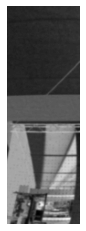

Predicted: tensor([9.9996e-01, 1.0608e-09, 3.6379e-05], device='cuda:0'), actual: tensor([1., 0., 0.], device='cuda:0')


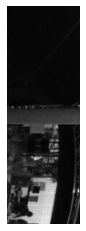

Predicted: tensor([1.6030e-17, 1.8367e-06, 1.0000e+00], device='cuda:0'), actual: tensor([0., 0., 1.], device='cuda:0')


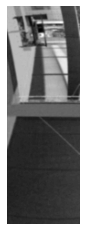

Predicted: tensor([3.2026e-04, 1.9414e-07, 9.9968e-01], device='cuda:0'), actual: tensor([0., 0., 1.], device='cuda:0')


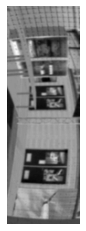

Predicted: tensor([1.4152e-06, 9.9999e-01, 4.4387e-06], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


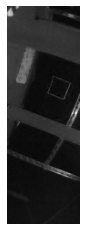

Predicted: tensor([0.0103, 0.9128, 0.0768], device='cuda:0'), actual: tensor([1., 0., 0.], device='cuda:0')


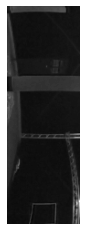

Predicted: tensor([1.8651e-05, 9.9997e-01, 7.5541e-06], device='cuda:0'), actual: tensor([0., 0., 1.], device='cuda:0')


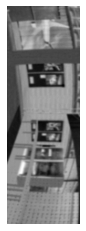

Predicted: tensor([5.1504e-05, 9.9995e-01, 9.0003e-09], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


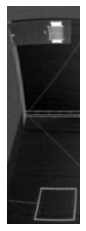

Predicted: tensor([2.6108e-08, 9.9997e-01, 2.6611e-05], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


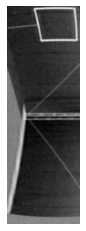

Predicted: tensor([4.8296e-03, 9.9511e-01, 6.0495e-05], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


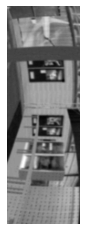

Predicted: tensor([3.5411e-04, 9.9965e-01, 6.8499e-09], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


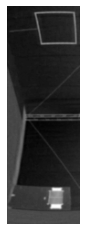

Predicted: tensor([2.7662e-05, 9.9997e-01, 1.2997e-08], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


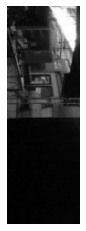

Predicted: tensor([4.8155e-12, 1.0000e+00, 4.6518e-18], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


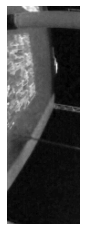

Predicted: tensor([1.3823e-01, 8.6177e-01, 2.8399e-06], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


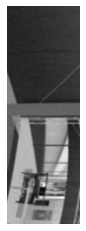

Predicted: tensor([9.9999e-01, 4.3215e-10, 1.3650e-05], device='cuda:0'), actual: tensor([1., 0., 0.], device='cuda:0')


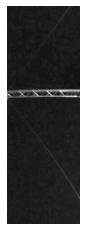

Predicted: tensor([0.2593, 0.7387, 0.0020], device='cuda:0'), actual: tensor([0., 0., 1.], device='cuda:0')


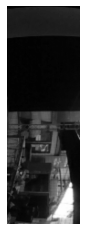

Predicted: tensor([2.1700e-15, 1.0000e+00, 3.9993e-17], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


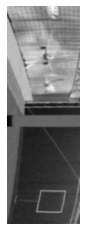

Predicted: tensor([9.9998e-01, 1.3740e-06, 1.4627e-05], device='cuda:0'), actual: tensor([1., 0., 0.], device='cuda:0')


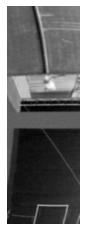

Predicted: tensor([9.9941e-01, 4.6085e-04, 1.2722e-04], device='cuda:0'), actual: tensor([1., 0., 0.], device='cuda:0')


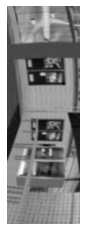

Predicted: tensor([1.2554e-05, 9.9999e-01, 3.8177e-10], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


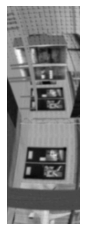

Predicted: tensor([8.8836e-08, 9.9993e-01, 6.7544e-05], device='cuda:0'), actual: tensor([0., 1., 0.], device='cuda:0')


In [11]:
# Show test images together with the predicted and actual labels
def show_predictions(model, loader, num_images=20):
    """
    Show images together with the predicted and actual labels.

    Args:
        model: The model to use for prediction.
        loader: The DataLoader for the dataset.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            for j in range(inputs.size(0)):
                img = inputs[j].permute(1, 2, 0).cpu().numpy()
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                plt.show()
                print(f'Predicted: {outputs[j]}, actual: {labels[j]}')
                num_images -= 1
                if num_images == 0:
                    return

show_predictions(best_model, test_loader)

In [12]:
# save model

torch.save(best_model.state_dict(), 'models/best_model_2.pth')

In [58]:
import os
sequence_path = 'test_sequence'

# fourcc and video for mp4 vidoe of the sequence, frames are RBG (540x270x3)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output.avi',fourcc, 10, (240,520))

for filename in os.listdir(sequence_path):
    img_path = os.path.join(sequence_path, filename)
    img = cv2.imread(img_path)

    img_trans = copy.deepcopy(img)
    img_trans = IMAGE_TRANSFORM(img_trans).unsqueeze(0)
    img_trans = img_trans.to(device)

    output = best_model(img_trans)

    # create video
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, f'Left: {output[0][0]:.2f}', (10, 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f'Forward: {output[0][1]:.2f}', (10, 60), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f'Right: {output[0][2]:.2f}', (10, 90), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    video.write(img)

video.release()

In [88]:
import os
sequence_path = 'test_sequence'

# fourcc and video for mp4 vidoe of the sequence, frames are RBG (540x270x3)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output.avi',fourcc, 10, (520,240))

for filename in os.listdir(sequence_path):
    img_path = os.path.join(sequence_path, filename)
    img = cv2.imread(img_path)

    img_trans = copy.deepcopy(img)
    img_trans = IMAGE_TRANSFORM(img_trans).unsqueeze(0)
    img_trans = img_trans.to(device)

    output = best_model(img_trans)

    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # create bar chart from output, then add to image in top right corner
    img = cv2.rectangle(img, (5,5), (85,55), (0, 0, 0), -1)
    img = cv2.rectangle(img, (10,50-int(output[0][0]*40)), (30,50), (255, 255, 255), -1)
    img = cv2.rectangle(img, (35,50-int(output[0][1]*40)), (55,50), (255, 255, 255), -1)
    img = cv2.rectangle(img, (60,50-int(output[0][2]*40)), (80,50), (255, 255, 255), -1)

    video.write(img)

video.release()